In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1213_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230130_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230113_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1030_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230102_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230203_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0928_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0905_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1002_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine

In [2]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)

In [4]:
# sort the files
all_files.sort()

In [5]:
# fetch all February files - filenames containing "FEB" or "202202"
feb_files = [file for file in all_files if re.search(r"FEB", file) or re.search(r"202202", file)]
feb_files

['/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip',
 '/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB27.csv.gzip',
 '/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip',
 '/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip']

In [6]:
tmp_df_list = []
for file in feb_files:
    print(f"Reading in {file}")
    # unzip and read in the csv file as a dataframe
    tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
    # append dataframe to temp list
    tmp_df_list.append(tmp_df)

print("Concatenating the DataFrames")
# concatenate the dataframes in the temp list row-wise
df= pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB27.csv.gzip
Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip
Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip
Concatenating the DataFrames
Concatenation complete!


In [7]:
df.shape

(1964538, 17)

In [8]:
df.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'extractedts'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964538 entries, 0 to 140383
Data columns (total 17 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   userid          int64 
 1   username        object
 2   acctdesc        object
 3   location        object
 4   following       int64 
 5   followers       int64 
 6   totaltweets     int64 
 7   usercreatedts   object
 8   tweetid         int64 
 9   tweetcreatedts  object
 10  retweetcount    int64 
 11  text            object
 12  hashtags        object
 13  language        object
 14  coordinates     object
 15  favorite_count  int64 
 16  extractedts     object
dtypes: int64(7), object(10)
memory usage: 269.8+ MB


In [10]:
df.isna().sum().sort_values(ascending=False)

coordinates       1964351
location           820475
acctdesc           413013
userid                  0
retweetcount            0
favorite_count          0
language                0
hashtags                0
text                    0
tweetid                 0
tweetcreatedts          0
username                0
usercreatedts           0
totaltweets             0
followers               0
following               0
extractedts             0
dtype: int64

In [11]:
earliest_tweet = df["tweetcreatedts"].min()
latest_tweet = df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-24 06:48:02.000000, and the latest was at 2022-02-28 23:31:22


Wait

In [12]:
print(f"There are {df['language'].nunique()} unique languages in this DataFrame.")
df["language"].unique()

There are 64 unique languages in this DataFrame.


array(['en', 'th', 'de', 'es', 'ta', 'tr', 'lt', 'fi', 'ru', 'und', 'fr',
       'ht', 'no', 'in', 'pl', 'uk', 'pt', 'ar', 'nl', 'bn', 'it', 'hi',
       'iw', 'ckb', 'ur', 'mr', 'el', 'ps', 'gu', 'ml', 'ja', 'ca', 'et',
       'zh', 'sv', 'fa', 'cs', 'te', 'da', 'or', 'tl', 'ro', 'ko', 'pa',
       'si', 'sl', 'bg', 'kn', 'my', 'lv', 'eu', 'vi', 'hu', 'am', 'is',
       'ka', 'sr', 'cy', 'ne', 'dv', 'sd', 'hy', 'km', 'lo'], dtype=object)

In [13]:
df.language.value_counts()

en    1192382
fr     123563
th     107255
es      99384
de      79634
       ...   
is         17
hy         12
km         10
dv          5
lo          2
Name: language, Length: 64, dtype: int64

<AxesSubplot:ylabel='language'>

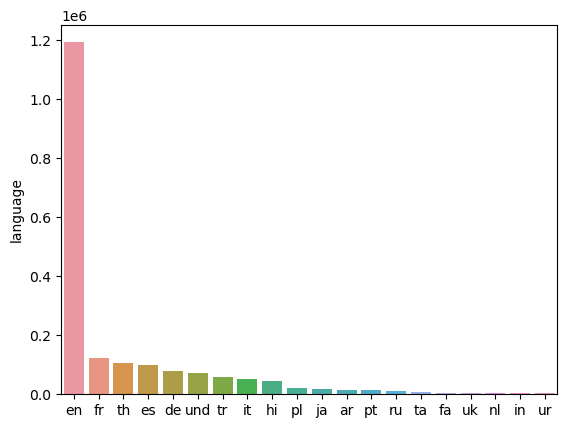

In [14]:
sns.barplot(x= df.language.value_counts()[:20].index,y=df.language.value_counts()[:20])

In [15]:
df.groupby('language').nunique()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,favorite_count,extractedts
language,,,,,,,,,,,,,,,,
am,63,63,45,19,64,81,88,63,88,88,23,52,44,0,3,88
ar,6858,6871,5309,1970,3080,4880,9805,6858,14357,13073,366,9174,8190,0,26,14357
bg,48,48,36,25,46,45,51,48,52,53,8,48,48,0,3,52
bn,254,254,210,107,234,401,537,254,571,585,27,506,470,0,8,571
ca,1237,1237,1012,607,987,942,1277,1237,1343,1348,144,812,747,0,8,1343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uk,4492,4493,3193,1619,1632,1585,4315,4492,5496,5195,779,2630,2216,1,13,5496
und,58007,58032,46215,18329,6698,7830,32383,57999,69165,42514,6299,41290,30972,7,32,69165
ur,2467,2467,1922,744,1571,1798,2940,2467,3228,3214,358,1652,1239,0,19,3228


In [16]:
#Only English Tweets
df_en = df[df.language == 'en'].drop('language', axis=1)

In [17]:
#Sort tweets 
sorted_tweets = df[['username', 'text','retweetcount','tweetid', ]].sort_values(by = 'retweetcount', ascending=False)

In [18]:
#Most retweeted
most_retweeted = sorted_tweets.iloc[0]
print(most_retweeted.text)

.@ZelenskyyUa's tv address to the Russian (!) people might be the most moving speech that I've ever seen in my entire life. The whole world needs to see, understand and share this crucial Ukrainian message.
#StandWithUkraine #Ukraine #Україна #Russia #Россия https://t.co/WoMOgqXTWX


In [19]:
#Top 10 most retweeted
sorted_tweets.head(10)

,username,text,retweetcount,tweetid
139082,Andrewrothchil1,.@ZelenskyyUa's tv address to the Russian (!) ...,145320,1498440449442435086
139963,bousuku_keyman,.@ZelenskyyUa's tv address to the Russian (!) ...,145320,1498440630669770755
139190,CarmenChincaro,.@ZelenskyyUa's tv address to the Russian (!) ...,145320,1498440473832165381
138489,jo_scorpion1234,.@ZelenskyyUa's tv address to the Russian (!) ...,145320,1498440322732355584
137696,takuma_DQX,.@ZelenskyyUa's tv address to the Russian (!) ...,145306,1498436817791877121
135693,alan_matts,.@ZelenskyyUa's tv address to the Russian (!) ...,145305,1498436314823368704
132663,8RFPm2Gm5Tr97jT,.@ZelenskyyUa's tv address to the Russian (!) ...,145300,1498432884679786497
132410,pazgarciac,.@ZelenskyyUa's tv address to the Russian (!) ...,145297,1498432857404063744
133782,PericaJerkovic,.@ZelenskyyUa's tv address to the Russian (!) ...,145296,1498433085649698823
133610,Valeria_AUT,.@ZelenskyyUa's tv address to the Russian (!) ...,145296,1498433051570941952


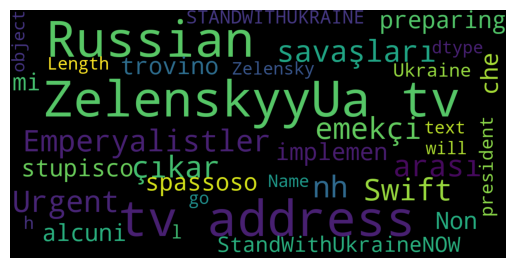

In [20]:
#WordCloud with STOPWORDS which is imported from wordcloud library
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 3,
                      random_state=42
                     ).generate(str(sorted_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
unique_tweets = df.drop_duplicates(subset = ['text'])

<AxesSubplot:>

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 3624 (\N{THAI CHARACTER SO SALA}) missing from current font.
  fun

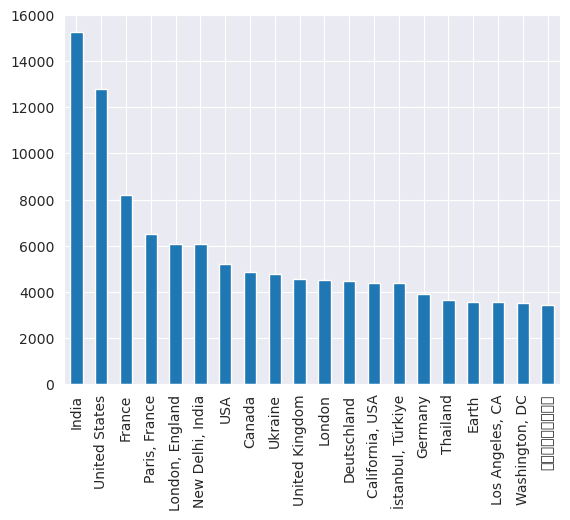

In [22]:
#Plotting tweets based on location of tweet
sns.set_style("darkgrid")#The error is occurring because the font being used does not have the necessary glyphs to display the Thai characters in the location names. To fix this error, we can change the font used in the plot to one that supports these glyphs.
df.location.value_counts()[:20].plot.bar()

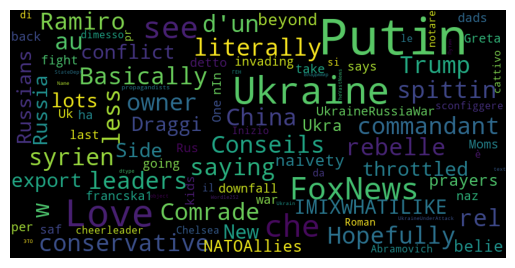

In [23]:
#Wordclouds using nltk stopwords based on unique tweets and ordered by number of retweets
stopwords_set = set(stopwords.words('english'))
wordcloud= WordCloud(background_color = 'black',
                    stopwords=stopwords_set,
                    max_words=300,
                    max_font_size=40,
                    scale = 2,
                    random_state=42
                    ).generate(str(unique_tweets.sort_values(by = 'retweetcount').iloc[:20]['text']))
print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
#Columns with time as a feature
time_cols = ['extractedts','tweetcreatedts','usercreatedts']

In [25]:
df[time_cols[2]] = pd.to_datetime(df[time_cols[2]])

In [26]:
df.head(10)

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,962369743,toonspt_,พยรลก 😉\nจะเปิดแอคเมื่อขายของเท่านั้น!!,NaN,462,7,20549,2012-11-21 13:01:19,1496738675085897729,2022-02-24 06:48:02.000000,1897,Footage of the airport bombing in Ivano-Franki...,"[{'text': 'Ukraine', 'indices': [68, 76]}, {'t...",en,NaN,0,2022-02-24 06:51:34.430620
1,865846412755353600,SabrinaBbsmith,อ้ายคือปริญญาใจน้องจึงยิ้มได้วันนี้ #สมรสเท่าเ...,Just go for it,385,503,84016,2017-05-20 08:27:26,1496738675140538368,2022-02-24 06:48:02.000000,3534,12.37 น. เจมส์ วอเตอร์เฮาส์ ผู้สื่อข่าว BBC ใน...,[],th,NaN,0,2022-02-24 06:51:34.421428
2,1927022036,haleggwenn,"Mathe & Kulturanthropologie • Feminismus, Anti...","Göttingen, Germany",251,51,78,2013-10-02 14:19:01,1496738675522248706,2022-02-24 06:48:02.000000,0,"Die Rede von #Putin ist echt gruselig:\n""Russl...","[{'text': 'Putin', 'indices': [13, 19]}, {'tex...",de,NaN,0,2022-02-24 06:51:34.412324
3,1073676020,IndiaTodayFLASH,No dragging feet on news. Crisp & short news s...,NaN,117,1152610,589066,2013-01-09 12:46:38,1496738675584954371,2022-02-24 06:48:02.000000,18,Ukraine MP Sophia Fedyna tells about the groun...,"[{'text': 'ITVideo', 'indices': [130, 138]}]",en,NaN,0,2022-02-24 06:51:34.403108
4,1484119658488033281,sandsand_fight,NaN,NaN,128,3,691,2022-01-20 11:05:01,1496738675710857224,2022-02-24 06:48:03.000000,3974,รัสเซียยิงขีปนาวุธรัวๆไปยังยูเครน\n#รัสเซียยูเ...,"[{'text': 'รัสเซียยูเครน', 'indices': [50, 64]...",th,NaN,0,2022-02-24 06:51:34.393984
5,1040140500718837760,Areopagiet,Dᴀᴅ ღ Pʜɪ & Qᴜɪ /Pᴀʀᴛɴᴇʀ | Aᴛʜᴇɪsᴛ | ADD /ASS ...,EU v2.0,5008,267,9894,2018-09-13 07:29:55,1496738676335734785,2022-02-24 06:48:03.000000,1552,A cruise missile fired by the Russian army fel...,"[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",en,NaN,0,2022-02-24 06:51:34.384864
6,1412931802184966145,Nancygaby271,NaN,NaN,115,1,5,2021-07-08 00:29:43,1496738676449099778,2022-02-24 06:48:03.000000,212,El momento del ataque con misiles en el aeropu...,"[{'text': 'Ukraine', 'indices': [84, 92]}, {'t...",es,NaN,0,2022-02-24 06:51:34.375720
7,1350117145498173441,harihar74331947,மாதவனின் பக்தன் 🚩🚩🚩ஓம் நமோ நாராயணா🚩🚩🚩,"Chennai, India",390,93,2391,2021-01-15 16:26:42,1496738676558073856,2022-02-24 06:48:03.000000,1,இன்று #ரஷ்யா தன்னுடைய ஒருங்கிணைந்த சோவியத் யூன...,"[{'text': 'ரஷ்யா', 'indices': [27, 33]}]",ta,NaN,0,2022-02-24 06:51:34.366602
8,2177253304,asemeyu,Asturiano residiendo en Huesca,Huesca,4177,4530,305815,2013-11-11 19:34:25,1496738676637941763,2022-02-24 06:48:03.000000,486,🇺🇦#UCRANIA - 🇷🇺#RUSIA 🚨#URGENTE | El quipo de ...,"[{'text': 'UCRANIA', 'indices': [20, 28]}, {'t...",es,NaN,0,2022-02-24 06:51:34.357466
9,1397060204152320002,ChWinvc,Shipper ୧ʕ•̀ᴥ•́ʔ୨ ตามใจตัวเอง อย่ามาสั่ง ||| S...,NaN,230,146,36385,2021-05-25 05:21:53,1496738676667084807,2022-02-24 06:48:03.000000,3441,‼️🚨เกิดเหตุระเบิดครั้งใหญ่ในเมืองท่าเรือ Mariu...,"[{'text': 'รัสเซียยูเครน', 'indices': [77, 91]...",th,NaN,0,2022-02-24 06:51:34.348322


In [27]:
#Dataframe with sorted date of creation of user id
sort_by_userage= df.sort_values(by = time_cols[2], ascending=True)

In [28]:
columns = df.columns.to_list()

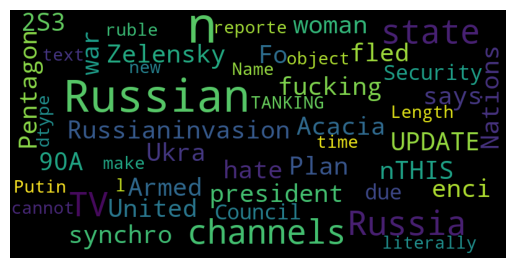

In [29]:
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(background_color='black',
                     stopwords = stopwords_set,
                     max_words = 300,
                     max_font_size = 40,
                      scale = 2,
                     random_state = 42
                     ).generate(str(sort_by_userage.iloc[:1000,columns.index('text')]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127481 (\N{REGIONAL INDICATOR SYMBOL LETTER T}) missing from current font.
  fig.c

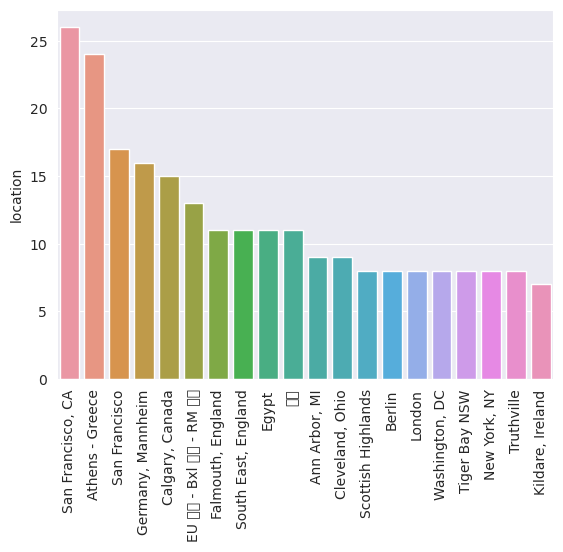

In [30]:
#Top 1000 sorted values
sns.barplot(x = sort_by_userage.iloc[:1000,columns.index('location')].value_counts()[:20].index,
           y = sort_by_userage.iloc[:1000, columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

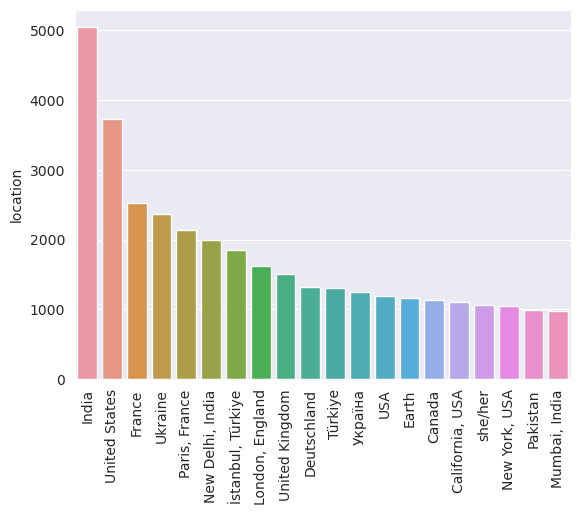

In [31]:
#Bottom 1000 sorted values
sns.barplot(x = sort_by_userage.iloc[df_en.shape[0]-1000:,
                                    columns.index('location')].value_counts()[:20].index,
           y= sort_by_userage.iloc[df_en.shape[0]-1000:,
                                  columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

# HASHTAG ANALYSIS

In [32]:
num_chars = df.text.apply(len)
num_words = df.text.apply(lambda x: len(x.split()))
df['num_chars'] = num_chars
df['num_words'] = num_words

In [33]:
print(f"average num characters: {num_chars.mean()}")
print(f"average num words : {num_words.mean()}")
print(f"median num characters: {num_chars.median()}")
print(f"median num words: {num_words.median()}")

average num characters: 188.3434497067504
average num words : 24.990820742586806
median num characters: 186.0
median num words: 24.0


In [34]:
df.groupby('num_chars')[['retweetcount', 'favorite_count']].describe()#wepass a list of keys instread of a tuple of keys

retweetcount                                                 \
                 count      mean        std  min  25%  50%  75%   max   
num_chars                                                               
4                  3.0  0.000000   0.000000  0.0  0.0  0.0  0.0   0.0   
5                 10.0  0.100000   0.316228  0.0  0.0  0.0  0.0   1.0   
6                 29.0  0.068966   0.257881  0.0  0.0  0.0  0.0   1.0   
7                 21.0  0.000000   0.000000  0.0  0.0  0.0  0.0   0.0   
8                177.0  2.005650  10.882376  0.0  0.0  0.0  0.0  96.0   
...                ...       ...        ...  ...  ...  ...  ...   ...   
1005               1.0  1.000000        NaN  1.0  1.0  1.0  1.0   1.0   
1018               1.0  0.000000        NaN  0.0  0.0  0.0  0.0   0.0   
1022               1.0  6.000000        NaN  6.0  6.0  6.0  6.0   6.0   
1025               1.0  8.000000        NaN  8.0  8.0  8.0  8.0   8.0   
1031               1.0  2.000000        NaN  2.0  2.0  2.0  2.0   2.0   

          favorite_count                                               
                   count      mean       std  min  25%  50%  75%  max  
num_chars                                                              
4                    3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
5                   10.0  0.100000  0.316228  0.0  0.0  0.0  0.0  1.0  
6                   29.0  0.172414  0.384426  0.0  0.0  0.0  0.0  1.0  
7                   21.0  0.047619  0.218218  0.0  0.0  0.0  0.0  1.0  
8                  177.0  0.045198  0.208327  0.0  0.0  0.0  0.0  1.0  
...                  ...       ...       ...  ...  ...  ...  ...  ...  
1005                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
1018                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0  
1022                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
1025                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
1031                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  

[681 rows x 16 columns]

In [35]:
df['tweetcreatedts'] = pd.to_datetime(df['tweetcreatedts'], errors='coerce')
df['extractedts'] = pd.to_datetime(df['extractedts'], errors='coerce') 
gc.collect()

12313

The code you provided defines a function named evaluate_hashtags that takes a parameter x and returns a list of hashtags extracted from the input parameter.

The function first imports the unidecode module from the unidecode package. This module is used to convert Unicode characters to their closest ASCII representation.

The function then initializes an empty list called hashtags and evaluates the input parameter x using the eval() function. This is done to convert the string representation of a Python list into an actual list object.

The function then iterates over each item in the list a, extracts the text of the hashtag using the key "text", converts it to lowercase using the lower() function, and converts any Unicode characters to their closest ASCII representation using the unidecode() function. The resulting string is then appended to the hashtags list.

Finally, the list of hashtags is converted to a set using the set() function to remove any duplicates, and then converted back to a list using the list() function before being returned.

Note that this code assumes that the input parameter x is a string representation of a list of dictionaries, where each dictionary represents a hashtag with a key "text" and a value that is the text of the hashtag. The eval() function is used to convert the string representation of the list into an actual list object. However, using eval() can be dangerous as it allows arbitrary code execution, so it's recommended to use a safer alternative like ast.literal_eval() instead.

In [36]:
from unidecode import unidecode
def evaluate_hashtags(x):
    hashtags = []
    
    a = eval(str(x))
    
    for item in a:
        hashtags.append((str(unidecode(item["text"])).lower()))
        hashtags = list(set(hashtags))
        
    return hashtags

In [37]:
masterlist = []
hashtagsListCollection = df["hashtags"].apply(evaluate_hashtags)

for hashtagsList in hashtagsListCollection:
    for hashtag in hashtagsList:
        masterlist.append(hashtag)

In [38]:
topXItem = 25
from collections import Counter

x = Counter(masterlist)

topXItemList = x.most_common(topXItem)

In [39]:
df_hash = pd.DataFrame(topXItemList)
df_hash.columns =['Hashtag','Tweets']
df_hash

,Hashtag,Tweets
0,ukraine,767494
1,russia,327355
2,putin,200933
3,kyiv,86786
4,ukrainerussiawar,74296
5,ukrainerussia,72010
6,russiaukrainewar,70428
7,russiaukraineconflict,57424
8,yuuekhrn,56064
9,ukraineunderattack,54341


In [40]:
dfpivot = df_hash.T
new_header = dfpivot.iloc[0] #grab the first row for the header
dfpivot = dfpivot[1:] #take the data less the header row
dfpivot.columns = new_header #set the header row as the df header
dfpivot

Hashtag,ukraine,russia,putin,kyiv,ukrainerussiawar,ukrainerussia,russiaukrainewar,russiaukraineconflict,yuuekhrn,ukraineunderattack,...,kiev,wwiii,worldwar3,standwithukraine,ukraineinvasion,ukrainian,ukraina,russiaukraine,zelensky,stoprussia
Tweets,767494,327355,200933,86786,74296,72010,70428,57424,56064,54341,...,43137,40995,38131,31842,29628,26786,26654,26624,25251,25192


<AxesSubplot:xlabel='Hashtag'>

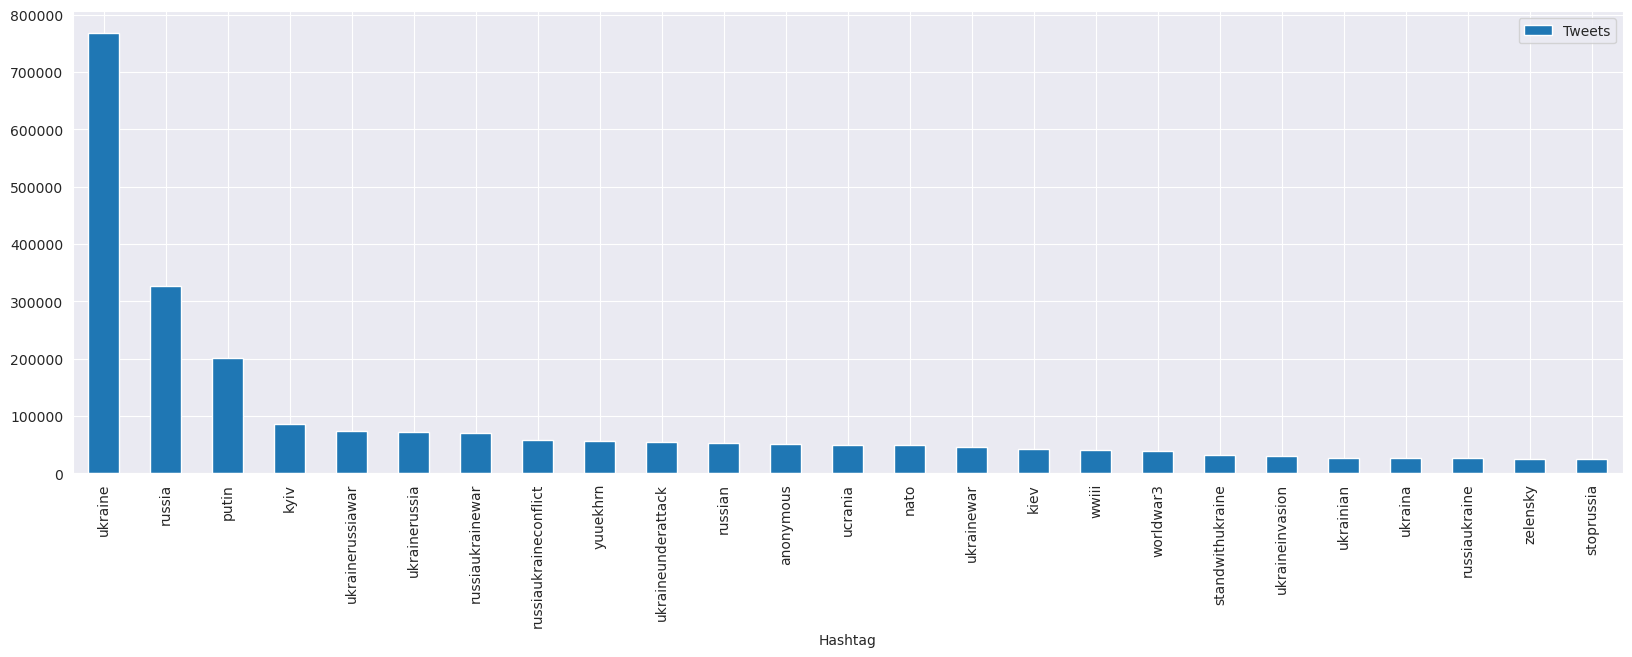

In [41]:
plt.rcParams["figure.figsize"] = [20, 6]
df_hash.plot.bar(x='Hashtag', y='Tweets', rot=90)

# -----------------------------------------------------------------------------------------